In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rdu = pd.read_csv("weather_station_data_20220915/rdu_station_data.csv")
rdu["date_time"] = rdu["date"] + " " + rdu["time"]
rdu['date_time'] = pd.to_datetime(rdu['date_time'])
rdu_sub = rdu[['date_time', 'wbgt','ta','rh','td','speed2m','solar','cloudcover','hi']]

In [3]:
warnings =  pd.read_csv("vtec_NCZ025_20140101_20221010.csv")

In [4]:
heat_warnings = warnings.loc[(warnings['ph_name'] == "Heat") | (warnings['ph_name'] == "Excessive Heat"),]
heat_warnings.loc[:,"issued"] = pd.to_datetime(heat_warnings.loc[:,"issued"])
heat_warnings.loc[:,"expired"] = pd.to_datetime(heat_warnings.loc[:,"expired"])
heat_warnings.loc[:,"issued"]= heat_warnings.issued.dt.to_period('h')
heat_warnings.loc[:,"expired"]= heat_warnings.expired.dt.to_period('h')

/Users/alisonreynolds/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [5]:
heat_warnings_neg = heat_warnings.loc[heat_warnings.issued > heat_warnings.expired,:]
heat_warnings_pos = pd.concat([heat_warnings, heat_warnings_neg,heat_warnings_neg]).drop_duplicates(keep=False)

In [6]:
heat_warnings_neg.rename(columns={"issued":"expired","expired":"issued"},inplace=True)

/Users/alisonreynolds/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
col_list = list(heat_warnings_neg)
col_list[1], col_list[3] = col_list[3], col_list[1]
heat_warnings_neg = heat_warnings_neg.reindex(columns=col_list)

In [8]:
heat_warnings_f = pd.concat([heat_warnings_pos,heat_warnings_neg], axis=0)
heat_warnings_f.loc[:,"hour_diff"] = heat_warnings_f.expired - heat_warnings_f.issued 

In [9]:
warning_dates = pd.DataFrame()

In [10]:
for i in range(len(heat_warnings_f)):
    x = heat_warnings_f.iloc[i,:]
    num = int(x.loc["hour_diff"].freqstr[0])
    num1 = num + 1
    date = x.loc["issued"]
    date_i = [x.loc["issued"] + 1 * i for i in range(num1)]
    warnings_i = [x.loc["name"]]* num1
    df_i = pd.DataFrame(columns = ['Date', 'Name'])
    df_i.loc[:,'Date'] = date_i
    df_i.loc[:,'Name'] = warnings_i
    warning_dates = pd.concat([warning_dates,df_i], axis=0)

In [11]:
rdu_sub.loc[:,"Date"] = rdu_sub.date_time.dt.to_period('h')

/Users/alisonreynolds/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [12]:
full_data = rdu_sub.join(warning_dates.set_index('Date'), how = "left", on='Date')

In [13]:
full_data.loc[:,"Heat"] = 1
full_data.loc[full_data['Name'].isna(),'Heat'] = 0
full_data.loc[full_data['Name'].isna(),'Name'] = "None"

In [14]:
corr = full_data.corr()

In [15]:
corr

,wbgt,ta,rh,td,speed2m,solar,cloudcover,hi,Heat
wbgt,1.000000,0.982715,0.068216,0.905574,0.168378,0.416543,0.164291,0.984337,0.091271
ta,0.982715,1.000000,-0.047209,0.862078,0.193629,0.394838,0.142490,0.996091,0.101281
rh,0.068216,-0.047209,1.000000,0.457707,-0.205036,-0.499888,0.324869,-0.008428,-0.041213
td,0.905574,0.862078,0.457707,1.000000,0.067286,0.092136,0.287356,0.879639,0.068816
speed2m,0.168378,0.193629,-0.205036,0.067286,1.000000,0.272665,0.168646,0.183573,0.032733
solar,0.416543,0.394838,-0.499888,0.092136,0.272665,1.000000,-0.201152,0.385474,0.065604
cloudcover,0.164291,0.142490,0.324869,0.287356,0.168646,-0.201152,1.000000,0.152490,0.008357
hi,0.984337,0.996091,-0.008428,0.879639,0.183573,0.385474,0.152490,1.000000,0.115770
Heat,0.091271,0.101281,-0.041213,0.068816,0.032733,0.065604,0.008357,0.115770,1.000000


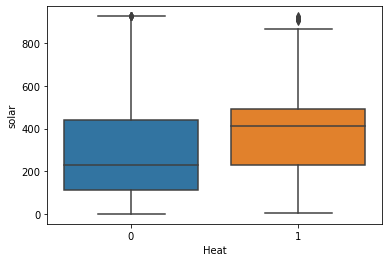

In [16]:
sns.boxplot(data=full_data.loc[full_data.solar != 0, :], x="Heat", y="solar")
plt.show()

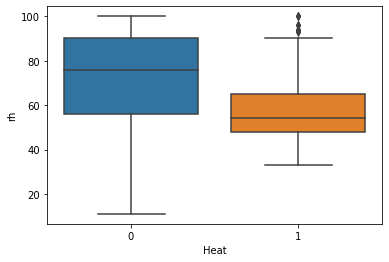

In [17]:
sns.boxplot(data=full_data, x="Heat", y="rh")
plt.show()

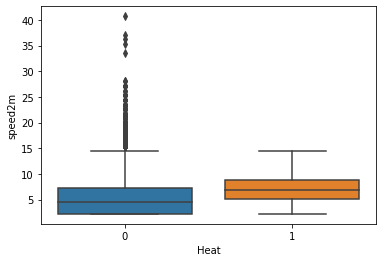

In [18]:
sns.boxplot(data=full_data, x="Heat", y="speed2m")
plt.show()

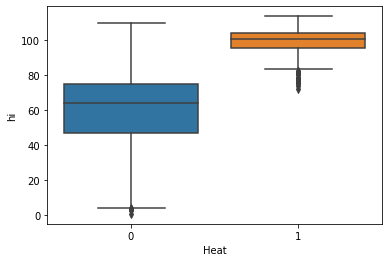

In [19]:
sns.boxplot(data=full_data, x="Heat", y="hi")
plt.show()

In [20]:
EH_Conditions = [
    (full_data['hi'] < 80),
    (full_data['hi'] >= 80) & (full_data['hi'] < 90),
    (full_data['hi'] >= 90) & (full_data['hi'] < 103),
    (full_data['hi'] >= 103) & (full_data['hi'] < 124),
    (full_data['hi'] >= 124)
]

EH_Categories = ['None','Caution', 'Extreme Caution', 'Danger', 'Extreme Danger']

full_data['EH'] = np.select(EH_Conditions, EH_Categories)

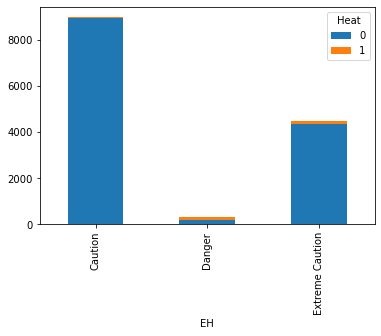

In [21]:
full_data.loc[full_data.EH != "None",:].groupby(['EH', 'Heat']).size().unstack().plot(kind='bar', stacked=True)
plt.show()